# Funciones

In [1]:
# Funciones
import seaborn as sns
import matplotlib.pyplot as plt

def plot_scatter_variables(df, target, variables=None):
    if variables is None:
        variables = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
        variables.remove(target)  # Eliminamos la variable objetivo

    num_vars = len(variables)
    cols = 3  # Número de columnas en la cuadrícula de subplots
    rows = (num_vars // cols) + (num_vars % cols > 0)  # Ajustar número de filas
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()  # Convertimos en un array 1D para indexar fácilmente

    for i, var in enumerate(variables):
        sns.scatterplot(x=df[var], y=df[target], ax=axes[i], alpha=0.6)
        axes[i].set_xlabel(var)
        axes[i].set_ylabel(target)
        axes[i].set_title(f'{var} vs {target}')
    
    # Ocultar ejes vacíos si sobran
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
def plot_correlation_heatmap(df, method=None):
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns  # Solo numéricas
    corr_matrix = df[numeric_cols].corr(method=method) if method else df[numeric_cols].corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5, cbar=True)
    plt.title('Correlación entre las Variables')
    plt.show()

# Carga de datos

In [2]:
import pandas as pd

# Cargar los datos
user_train = pd.read_csv("../train/user_train.csv", delimiter=";")
session_train = pd.read_csv("../train/session_train.csv")
user_test = pd.read_csv("../test/user_test.csv", delimiter=";")
session_test = pd.read_csv("../test/session_test.csv")

print(user_train.info()) 
print(session_train.info())
print(user_test.info())
print(session_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           700 non-null    object
 1   age               700 non-null    int64 
 2   abandoned_cart    700 non-null    bool  
 3   user_category     700 non-null    object
 4   marketing_target  700 non-null    int64 
dtypes: bool(1), int64(2), object(2)
memory usage: 22.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6877 entries, 0 to 6876
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           6877 non-null   object
 1   session_id        6877 non-null   object
 2   timestamp         6877 non-null   object
 3   device_type       6877 non-null   object
 4   browser           6877 non-null   object
 5   operating_system  6877 non-null   object
 6   ip_address        6877 non-nu

# Merge de datasets

In [3]:
import numpy as np
import pandas as pd

# 📌 1️⃣ Convertir timestamp a datetime antes del merge
for df in [session_train, session_test]:
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["day_of_week"] = df["timestamp"].dt.dayofweek
    df["hour_of_day"] = df["timestamp"].dt.hour

# 📌 2️⃣ Merge de usuarios y sesiones antes de calcular features
full_train = user_train.merge(session_train, on="user_id", how="left")
full_test = user_test.merge(session_test, on="user_id", how="left")

# 📌 3️⃣ Calcular features de sesiones sobre el dataset completo
session_features_train = full_train.groupby("user_id").agg(
    total_sessions=("session_id", "count"),
    avg_session_duration=("session_duration", "mean"),
    total_page_views=("page_views", "sum"),
    total_session_duration=("session_duration", "sum"),
    median_day_of_week=("day_of_week", "median"),
    median_hour_of_day=("hour_of_day", "median")
).reset_index()

session_features_test = full_test.groupby("user_id").agg(
    total_sessions=("session_id", "count"),
    avg_session_duration=("session_duration", "mean"),
    total_page_views=("page_views", "sum"),
    total_session_duration=("session_duration", "sum"),
    median_day_of_week=("day_of_week", "median"),
    median_hour_of_day=("hour_of_day", "median")
).reset_index()

# 📌 4️⃣ Aplicar transformación logarítmica a total_page_views
session_features_train["log_total_page_views"] = np.log1p(session_features_train["total_page_views"])
session_features_test["log_total_page_views"] = np.log1p(session_features_test["total_page_views"])

# 📌 5️⃣ Mergear de nuevo para incorporar las nuevas features
full_train = full_train.merge(session_features_train, on="user_id", how="left")
full_test = full_test.merge(session_features_test, on="user_id", how="left")

# 📌 6️⃣ Verificar la salida
print("🔹 Información de full_train:")
print(full_train.info())

print("\n🔹 Información de full_test:")
print(full_test.info())

# 📌 7️⃣ Confirmar que las columnas coinciden correctamente
print("\n🔹 Verificación de columnas:")
print("Columnas en train:", list(full_train.columns))
print("Columnas en test:", list(full_test.columns))


🔹 Información de full_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6877 entries, 0 to 6876
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   user_id                 6877 non-null   object        
 1   age                     6877 non-null   int64         
 2   abandoned_cart          6877 non-null   bool          
 3   user_category           6877 non-null   object        
 4   marketing_target        6877 non-null   int64         
 5   session_id              6877 non-null   object        
 6   timestamp               6877 non-null   datetime64[ns]
 7   device_type             6877 non-null   object        
 8   browser                 6877 non-null   object        
 9   operating_system        6877 non-null   object        
 10  ip_address              6877 non-null   object        
 11  country                 6877 non-null   object        
 12  search_query       

# Análisis de los datasets

## .describe()

In [4]:
full_train.describe(include="all")

,user_id,age,abandoned_cart,user_category,marketing_target,session_id,timestamp,device_type,browser,operating_system,...,session_duration,day_of_week,hour_of_day,total_sessions,avg_session_duration,total_page_views,total_session_duration,median_day_of_week,median_hour_of_day,log_total_page_views
count,6877,6877.000000,6877,6877,6877.000000,6877,6877,6877,6877,6877,...,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000
unique,700,NaN,2,3,NaN,6877,NaN,3,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,97e9275b-3f3e-4a98-957e-c02c005033ec,NaN,False,premium_subscriber,NaN,9dfa4690-0f5e-410e-adc0-ff6d3b4a3bab,NaN,tablet,Edge,iOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,15,NaN,3516,2374,NaN,1,NaN,2345,1782,1429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,43.835248,NaN,NaN,1.319471,NaN,2023-05-31 03:50:18.188018176,NaN,NaN,NaN,...,160.271630,2.969027,11.456158,10.818526,160.271630,70.776211,1734.328341,2.973826,11.484368,4.223656
min,NaN,18.000000,NaN,NaN,1.000000,NaN,2023-01-01 04:26:09,NaN,NaN,NaN,...,20.000000,0.000000,0.000000,5.000000,85.666667,23.000000,441.000000,0.000000,2.000000,3.178054
25%,NaN,31.000000,NaN,NaN,1.000000,NaN,2023-03-17 21:18:34,NaN,NaN,NaN,...,90.000000,1.000000,5.000000,8.000000,142.307692,54.000000,1315.000000,2.000000,9.000000,4.007333
50%,NaN,44.000000,NaN,NaN,1.000000,NaN,2023-05-30 23:36:15,NaN,NaN,NaN,...,161.000000,3.000000,11.000000,11.000000,159.142857,71.000000,1758.000000,3.000000,11.500000,4.276666
75%,NaN,56.000000,NaN,NaN,1.000000,NaN,2023-08-13 09:50:43,NaN,NaN,NaN,...,228.000000,5.000000,17.000000,14.000000,177.071429,89.000000,2123.000000,4.000000,14.000000,4.499810
max,NaN,70.000000,NaN,NaN,3.000000,NaN,2023-10-28 06:51:17,NaN,NaN,NaN,...,300.000000,6.000000,23.000000,15.000000,244.500000,122.000000,3298.000000,6.000000,21.000000,4.812184


In [5]:
full_test.describe(include="all")

,user_id,age,abandoned_cart,user_category,test_id,session_id,timestamp,device_type,browser,operating_system,...,session_duration,day_of_week,hour_of_day,total_sessions,avg_session_duration,total_page_views,total_session_duration,median_day_of_week,median_hour_of_day,log_total_page_views
count,3026,3026.000000,3026,3026,3026.000000,3026,3026,3026,3026,3026,...,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000
unique,300,NaN,2,3,NaN,3026,NaN,3,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,541da13d-6f7c-4618-8653-4df09befd7f1,NaN,False,new_user,NaN,44052e87-999b-4102-b0f7-003ab6cb8442,NaN,tablet,Safari,Windows,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,15,NaN,1614,1098,NaN,1,NaN,1026,781,612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,43.287508,NaN,NaN,152.483146,NaN,2023-05-31 06:09:12.283873280,NaN,NaN,NaN,...,158.589227,3.048579,11.465631,11.198282,158.589227,72.424323,1777.486120,3.131857,11.398546,4.243196
min,NaN,18.000000,NaN,NaN,1.000000,NaN,2023-01-01 09:49:38,NaN,NaN,NaN,...,20.000000,0.000000,0.000000,5.000000,72.200000,23.000000,361.000000,0.000000,3.000000,3.178054
25%,NaN,30.000000,NaN,NaN,77.000000,NaN,2023-03-18 16:10:11.249999872,NaN,NaN,NaN,...,87.250000,1.000000,5.000000,9.000000,144.000000,56.000000,1343.000000,2.500000,9.000000,4.043051
50%,NaN,44.000000,NaN,NaN,154.500000,NaN,2023-05-30 04:06:39.500000,NaN,NaN,NaN,...,160.000000,3.000000,11.000000,12.000000,159.890909,74.000000,1829.000000,3.000000,11.000000,4.317488
75%,NaN,56.000000,NaN,NaN,229.000000,NaN,2023-08-12 14:44:31,NaN,NaN,NaN,...,232.000000,5.000000,18.000000,14.000000,174.000000,92.000000,2229.000000,4.000000,14.000000,4.532599
max,NaN,70.000000,NaN,NaN,300.000000,NaN,2023-10-28 07:42:51,NaN,NaN,NaN,...,300.000000,6.000000,23.000000,15.000000,265.500000,115.000000,3081.000000,6.000000,20.000000,4.753590


## Análisis variables categóricas

In [6]:
# 📌 1️⃣ Seleccionar variables categóricas
categorical_cols = ["user_category", "device_type", "browser", "operating_system", "country"]

# 📌 2️⃣ Analizar valores únicos y frecuencia en train
print("🔹 Valores únicos y frecuencias en full_train:")
for col in categorical_cols:
    print(f"\n📊 {col}:")
    print(full_train[col].value_counts())

# 📌 3️⃣ Analizar valores únicos y frecuencia en test
print("\n🔹 Valores únicos y frecuencias en full_test:")
for col in categorical_cols:
    print(f"\n📊 {col}:")
    print(full_test[col].value_counts())

# 📌 4️⃣ Comparar categorías entre train y test
print("\n🔎 Comparación de categorías entre train y test:")
for col in categorical_cols:
    train_categories = set(full_train[col].unique())
    test_categories = set(full_test[col].unique())

    missing_in_test = train_categories - test_categories
    missing_in_train = test_categories - train_categories

    print(f"\n📌 {col}:")
    print(f" - Categorías en train pero no en test: {missing_in_test}")
    print(f" - Categorías en test pero no en train: {missing_in_train}")


🔹 Valores únicos y frecuencias en full_train:

📊 user_category:
user_category
premium_subscriber    2374
new_user              2306
recurring_user        2197
Name: count, dtype: int64

📊 device_type:
device_type
tablet     2345
mobile     2279
desktop    2253
Name: count, dtype: int64

📊 browser:
browser
Edge       1782
Chrome     1728
Safari     1693
Firefox    1674
Name: count, dtype: int64

📊 operating_system:
operating_system
iOS        1429
macOS      1384
Windows    1367
Android    1360
Linux      1337
Name: count, dtype: int64

📊 country:
country
Korea            57
Congo            53
Taiwan           46
Faroe Islands    41
Anguilla         40
                 ..
India            19
Colombia         18
Switzerland      17
Saint Lucia      17
Malaysia         15
Name: count, Length: 243, dtype: int64

🔹 Valores únicos y frecuencias en full_test:

📊 user_category:
user_category
new_user              1098
premium_subscriber     982
recurring_user         946
Name: count, dtype: i

## LabelEncoding + TargetEncoding("country")
- categorical_features = ["user_category", "device_type", "browser", "operating_system"]

In [7]:
from sklearn.preprocessing import LabelEncoder

# 📌 1️⃣ Aplicar Label Encoding a user_category, device_type, browser, operating_system
categorical_features = ["user_category", "device_type", "browser", "operating_system"]
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    full_train[col] = le.fit_transform(full_train[col])  # Ajustar y transformar en train
    full_test[col] = le.transform(full_test[col])  # Transformar en test con las mismas categorías
    label_encoders[col] = le  # Guardamos el encoder por si lo necesitamos luego

# 📌 2️⃣ Aplicar Target Encoding en country
# Calcular la media de marketing_target por país en train
country_target_mean = full_train.groupby("country")["marketing_target"].mean().to_dict()

# Crear una nueva columna codificada en train
full_train["country_encoded"] = full_train["country"].map(country_target_mean)

# Reemplazar valores en test con los valores aprendidos en train
# Si un país no estaba en train, asignamos la media general de train
global_mean = full_train["country_encoded"].mean()
full_test["country_encoded"] = full_test["country"].map(country_target_mean).fillna(global_mean)

# 📌 3️⃣ Verificar la salida
print("🔹 Label Encoding aplicado correctamente:")
for col in categorical_features:
    print(f"{col}: {full_train[col].unique()}")

print("\n🔹 Target Encoding aplicado correctamente en country:")
print(full_train[["country", "country_encoded"]].head())
print(full_test[["country", "country_encoded"]].head())


🔹 Label Encoding aplicado correctamente:
user_category: [1 2 0]
device_type: [1 0 2]
browser: [3 2 0 1]
operating_system: [2 4 0 3 1]

🔹 Target Encoding aplicado correctamente en country:
                    country  country_encoded
0                 Lithuania         1.269231
1  United States of America         1.407407
2                   Moldova         1.297297
3                     Gabon         1.260870
4                Mozambique         1.285714
      country  country_encoded
0   Argentina         1.185185
1    Pakistan         1.333333
2  Uzbekistan         1.476190
3       Yemen         1.136364
4        Cuba         1.400000


## Histograma

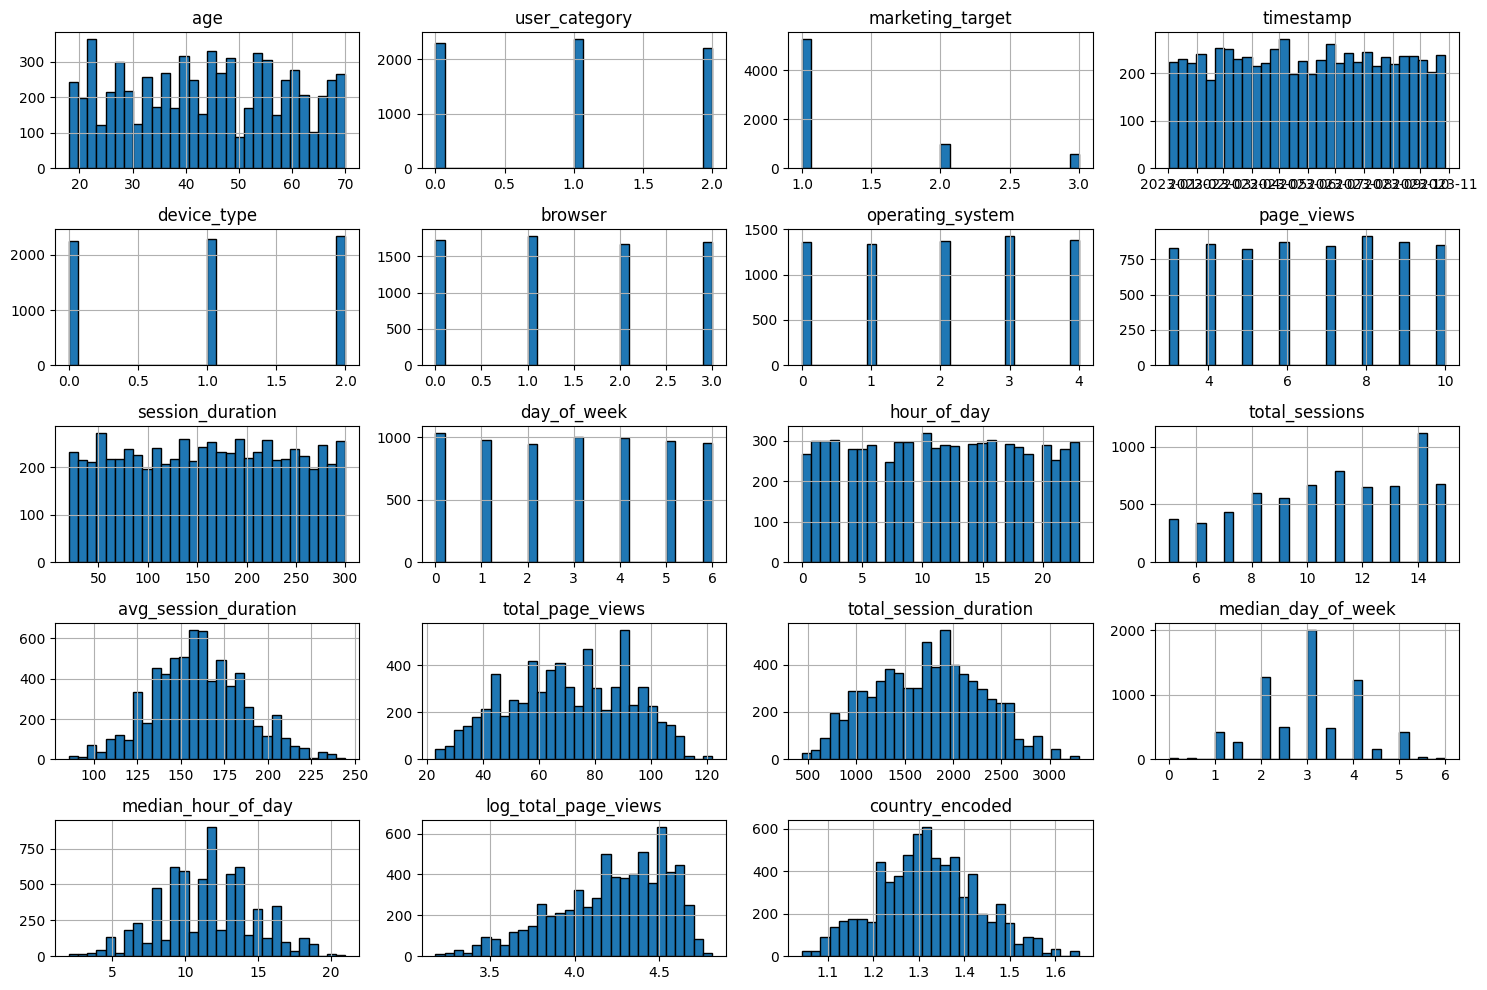

In [8]:
full_train.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.show()

## Scatter

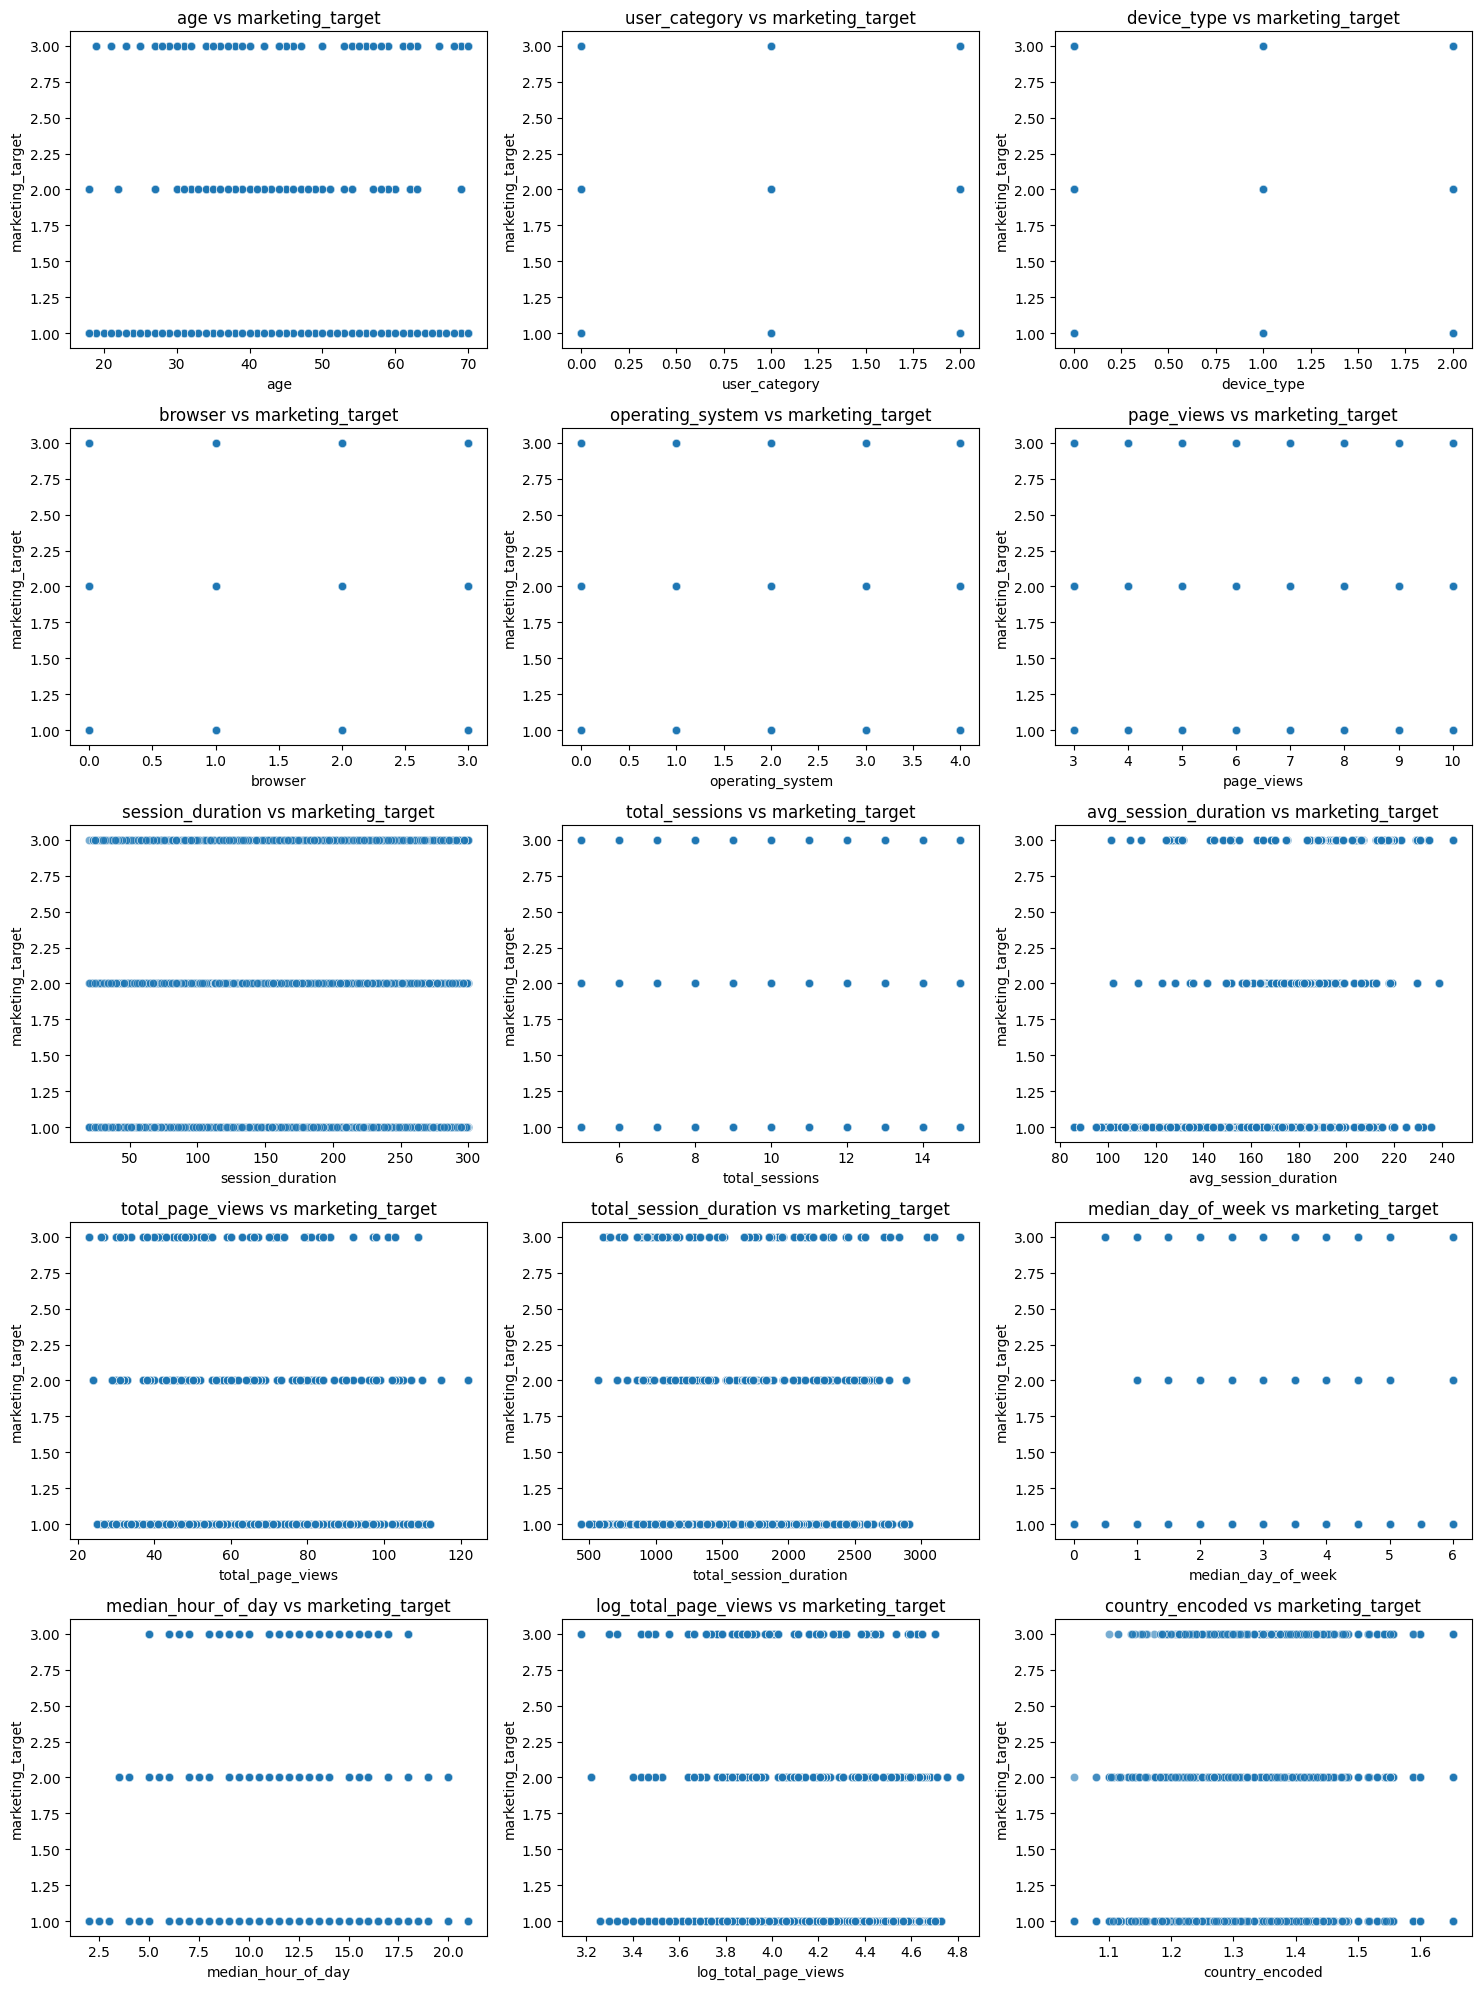

In [9]:
plot_scatter_variables(full_train, target="marketing_target")

## Correlation

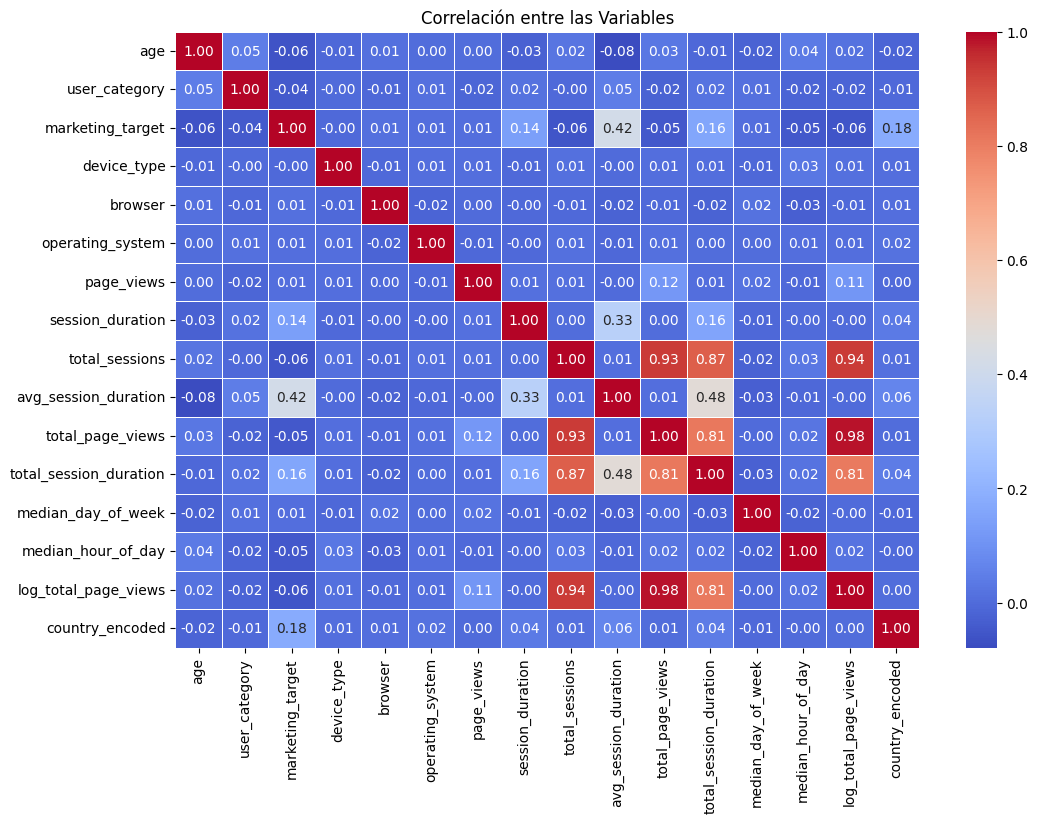

In [10]:
plot_correlation_heatmap(full_train)

## Eliminación variables redundantes

✅ Mantenemos:
- log_total_page_views (en lugar de total_page_views)
- avg_session_duration (en lugar de total_session_duration)

❌ Eliminamos:
- total_sessions (redundante con log_total_page_views)
- total_session_duration (redundante con avg_session_duration)
- median_day_of_week (poca correlación con marketing_target)
- median_hour_of_day (poca correlación con marketing_target)
- total_page_views (porque usamos la versión logarítmica)

In [11]:
# 📌 1️⃣ Eliminar variables redundantes y no informativas
columns_to_drop = [
    "total_sessions", 
    "total_session_duration", 
    "median_day_of_week", 
    "median_hour_of_day", 
    "total_page_views"
]

full_train.drop(columns=columns_to_drop, inplace=True)
full_test.drop(columns=columns_to_drop, inplace=True)

# 📌 2️⃣ Verificar que las columnas se alinean correctamente
print("🔹 Columnas finales en full_train:", list(full_train.columns))
print("🔹 Columnas finales en full_test:", list(full_test.columns))


🔹 Columnas finales en full_train: ['user_id', 'age', 'abandoned_cart', 'user_category', 'marketing_target', 'session_id', 'timestamp', 'device_type', 'browser', 'operating_system', 'ip_address', 'country', 'search_query', 'page_views', 'session_duration', 'day_of_week', 'hour_of_day', 'avg_session_duration', 'log_total_page_views', 'country_encoded']
🔹 Columnas finales en full_test: ['user_id', 'age', 'abandoned_cart', 'user_category', 'test_id', 'session_id', 'timestamp', 'device_type', 'browser', 'operating_system', 'ip_address', 'country', 'search_query', 'page_views', 'session_duration', 'day_of_week', 'hour_of_day', 'avg_session_duration', 'log_total_page_views', 'country_encoded']


# Validación final

## Nulos

In [12]:
print("🔹 Valores nulos en full_train:")
print(full_train.isnull().sum())

print("\n🔹 Valores nulos en full_test:")
print(full_test.isnull().sum())


🔹 Valores nulos en full_train:
user_id                 0
age                     0
abandoned_cart          0
user_category           0
marketing_target        0
session_id              0
timestamp               0
device_type             0
browser                 0
operating_system        0
ip_address              0
country                 0
search_query            0
page_views              0
session_duration        0
day_of_week             0
hour_of_day             0
avg_session_duration    0
log_total_page_views    0
country_encoded         0
dtype: int64

🔹 Valores nulos en full_test:
user_id                 0
age                     0
abandoned_cart          0
user_category           0
test_id                 0
session_id              0
timestamp               0
device_type             0
browser                 0
operating_system        0
ip_address              0
country                 0
search_query            0
page_views              0
session_duration        0
day_of_week    

## .info()

In [13]:
print(full_train.info())
print(full_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6877 entries, 0 to 6876
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               6877 non-null   object        
 1   age                   6877 non-null   int64         
 2   abandoned_cart        6877 non-null   bool          
 3   user_category         6877 non-null   int64         
 4   marketing_target      6877 non-null   int64         
 5   session_id            6877 non-null   object        
 6   timestamp             6877 non-null   datetime64[ns]
 7   device_type           6877 non-null   int64         
 8   browser               6877 non-null   int64         
 9   operating_system      6877 non-null   int64         
 10  ip_address            6877 non-null   object        
 11  country               6877 non-null   object        
 12  search_query          6877 non-null   object        
 13  page_views        

# Benchmark inicial - RF - 720/900



In [14]:
import json
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# 📌 1️⃣ Preparar datos (Eliminamos "country" y confirmamos que solo usamos "country_encoded")
X_train = full_train.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "marketing_target", "country"])
y_train = full_train["marketing_target"]
X_test = full_test.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "test_id", "country"])  # Test no tiene target

# 📌 3️⃣ Configurar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 📌 4️⃣ Evaluación con CV optimizada
cv_results = cross_validate(
    rf_model, X_train, y_train, cv=cv,
    scoring=["f1_macro", "f1_weighted", "accuracy", "roc_auc_ovr"],
    n_jobs=-1, return_train_score=False
)

# 📌 5️⃣ Mostrar resultados
print("🔹 Resultados de Validación Cruzada:")
for metric in ["f1_macro", "f1_weighted", "accuracy", "roc_auc_ovr"]:
    print(f"{metric}: {np.mean(cv_results[f'test_{metric}']):.4f} ± {np.std(cv_results[f'test_{metric}']):.4f}")

# 📌 6️⃣ Entrenar modelo final con todo el dataset
rf_model.fit(X_train, y_train)

# 📌 7️⃣ Generar predicciones
predictions = rf_model.predict(X_test)

# 📌 8️⃣ Guardar en JSON
predictions_dict = {"target": {int(k): int(v) for k, v in zip(full_test["test_id"], predictions)}}

with open("../predictions/predictions.json", "w") as f:
    json.dump(predictions_dict, f)

print("✅ Modelo RF entrenado y predicciones guardadas en predictions.json")


🔹 Resultados de Validación Cruzada:
f1_macro: 0.8633 ± 0.0068
f1_weighted: 0.9273 ± 0.0036
accuracy: 0.9309 ± 0.0034
roc_auc_ovr: 0.9886 ± 0.0016
✅ Modelo RF entrenado y predicciones guardadas en predictions.json


# Benchmark inicial - LGB


## Inicial - 723/900

In [15]:
import json
import time
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# 📌 1️⃣ Preparar datos (Eliminamos "country" y usamos "country_encoded")
X_train = full_train.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "marketing_target", "country"])
y_train = full_train["marketing_target"]
X_test = full_test.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "test_id", "country"])  # Test no tiene target

# 📌 3️⃣ Configurar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configuración de LightGBM con n_jobs=1 para evitar nested parallelism
lgb_model = LGBMClassifier(
    random_state=42,
    n_jobs=1,         # Limitar la paralelización en el modelo
    verbose=-1,
    force_col_wise=True
)

# Medir tiempo de validación cruzada
start = time.time()
cv_results = cross_validate(
    lgb_model, X_train, y_train, cv=cv,
    scoring=["f1_macro", "f1_weighted", "accuracy", "roc_auc_ovr"],
    n_jobs=1,  # Ejecutar CV secuencialmente
    return_train_score=False
)
print("Tiempo de validación cruzada: {:.2f} segundos".format(time.time() - start))

# Mostrar resultados de la validación cruzada
print("🔹 Resultados de Validación Cruzada con LightGBM:")
for metric in ["f1_macro", "f1_weighted", "accuracy", "roc_auc_ovr"]:
    mean_score = np.mean(cv_results[f'test_{metric}'])
    std_score = np.std(cv_results[f'test_{metric}'])
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")

# Entrenar el modelo final con todo el dataset y medir tiempo
start = time.time()
lgb_model.fit(X_train, y_train)
print("Tiempo de entrenamiento final: {:.2f} segundos".format(time.time() - start))

# Generar predicciones sobre el conjunto de test
predictions = lgb_model.predict(X_test)

# Guardar las predicciones en un archivo JSON
predictions_dict = {"target": {int(test_id): int(pred) for test_id, pred in zip(full_test["test_id"], predictions)}}
with open("../predictions/predictions.json", "w") as f:
    json.dump(predictions_dict, f)

print("✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json")


Tiempo de validación cruzada: 0.89 segundos
🔹 Resultados de Validación Cruzada con LightGBM:
f1_macro: 0.9997 ± 0.0006
f1_weighted: 0.9999 ± 0.0003
accuracy: 0.9999 ± 0.0003
roc_auc_ovr: 1.0000 ± 0.0000
Tiempo de entrenamiento final: 0.15 segundos
✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json


## RandomizedSearchCV - 731/900

- Mejores hiperparámetros: 
```py
    {
    'subsample': 1.0, 
    'num_leaves': 31, 
    'n_estimators': 100,    
    'min_child_samples': 50, 
    'max_depth': 7, 
    'learning_rate': 0.05, 
    'lambda_l2': 0, 
    'lambda_l1': 0.1, 
    'colsample_bytree': 1.0
    }
```
- Mejor puntuación f1_macro: 0.6692492432791253

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

# Definir el espacio de hiperparámetros a explorar
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, -1],  # -1 indica que no se limita la profundidad
    'num_leaves': [15, 31, 63],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'lambda_l1': [0, 0.1, 0.5],
    'lambda_l2': [0, 0.1, 0.5]
}

# Configurar el modelo con n_jobs=1 para evitar nested parallelism
lgb_model = LGBMClassifier(
    random_state=42,
    n_jobs=1,
    verbose=-1,
    force_col_wise=True
)

# Configurar el RandomizedSearchCV centrado en f1_macro
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_distributions,
    n_iter=30,           # Número de combinaciones a probar
    scoring='f1_macro',  # Usamos f1_macro como métrica de evaluación
    cv=5,
    random_state=42,
    n_jobs=1            # Ejecutar de forma secuencial para evitar sobrecarga
)

# Entrenar la búsqueda de hiperparámetros
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros y la mejor puntuación obtenida en f1_macro
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor puntuación f1_macro:", random_search.best_score_)


Mejores hiperparámetros: {'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 50, 'max_depth': 7, 'learning_rate': 0.05, 'lambda_l2': 0, 'lambda_l1': 0.1, 'colsample_bytree': 1.0}
Mejor puntuación f1_macro: 0.6692492432791253


In [17]:
import json
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier

# 📌 1️⃣ Preparar los datos
# Se eliminan las columnas que no se utilizarán en el entrenamiento
X_train = full_train.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "marketing_target", "country"])
y_train = full_train["marketing_target"]

X_test = full_test.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "test_id", "country"])

# 📌 2️⃣ Configurar el modelo con los hiperparámetros óptimos
# Hiperparámetros obtenidos:
# {'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 50,
#  'max_depth': 7, 'learning_rate': 0.05, 'lambda_l2': 0, 'lambda_l1': 0.1, 'colsample_bytree': 1.0}
lgb_model_best = LGBMClassifier(
    subsample=1.0,
    num_leaves=31,
    n_estimators=100,
    min_child_samples=50,
    max_depth=7,
    learning_rate=0.05,
    lambda_l2=0,
    lambda_l1=0.1,
    colsample_bytree=1.0,
    random_state=42,
    n_jobs=1,           # Para evitar nested parallelism
    verbose=-1,
    force_col_wise=True
)

# 📌 3️⃣ Entrenar el modelo con todo el dataset de entrenamiento
lgb_model_best.fit(X_train, y_train)

# 📌 4️⃣ Generar las predicciones para el conjunto de test
predictions = lgb_model_best.predict(X_test)

# 📌 5️⃣ Guardar las predicciones en un archivo JSON
predictions_dict = {
    "target": {int(test_id): int(pred) for test_id, pred in zip(full_test["test_id"], predictions)}
}

with open("../predictions/predictions.json", "w") as f:
    json.dump(predictions_dict, f)

print("✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json")


✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json


## class_weight='balanced' - 739/900

In [18]:
import json
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier

# 📌 1️⃣ Preparar los datos
# Se eliminan las columnas que no se utilizarán en el entrenamiento
X_train = full_train.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "marketing_target", "country"])
y_train = full_train["marketing_target"]

X_test = full_test.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "test_id", "country"])

# 📌 2️⃣ Configurar el modelo con los hiperparámetros óptimos
# Hiperparámetros obtenidos:
# {'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 50,
#  'max_depth': 7, 'learning_rate': 0.05, 'lambda_l2': 0, 'lambda_l1': 0.1, 'colsample_bytree': 1.0}
lgb_model_best = LGBMClassifier(
    subsample=1.0,
    num_leaves=31,
    n_estimators=100,
    min_child_samples=50,
    max_depth=7,
    learning_rate=0.05,
    lambda_l2=0,
    lambda_l1=0.1,
    colsample_bytree=1.0,
    random_state=42,
    n_jobs=1,           # Para evitar nested parallelism
    verbose=-1,
    force_col_wise=True,
    class_weight="balanced"
)

# 📌 3️⃣ Entrenar el modelo con todo el dataset de entrenamiento
lgb_model_best.fit(X_train, y_train)

# 📌 4️⃣ Generar las predicciones para el conjunto de test
predictions = lgb_model_best.predict(X_test)

# 📌 5️⃣ Guardar las predicciones en un archivo JSON
predictions_dict = {
    "target": {int(test_id): int(pred) for test_id, pred in zip(full_test["test_id"], predictions)}
}

with open("../predictions/predictions.json", "w") as f:
    json.dump(predictions_dict, f)

print("✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json")


✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json


## Validación Cruzada Robustecida: Repeated Stratified K-Fold - 739/900 (mismo resultado)

In [19]:
import json
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

# -----------------------------------------------------------------------------
# 1️⃣ Preparar los datos
# Se eliminan las columnas que no se utilizarán en el entrenamiento.
X_train = full_train.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "marketing_target", "country"])
y_train = full_train["marketing_target"]

X_test = full_test.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "test_id", "country"])

# -----------------------------------------------------------------------------
# 2️⃣ Configurar el modelo con los hiperparámetros óptimos y class_weight balanced.
lgb_model_best = LGBMClassifier(
    subsample=1.0,
    num_leaves=31,
    n_estimators=100,
    min_child_samples=50,
    max_depth=7,
    learning_rate=0.05,
    lambda_l2=0,
    lambda_l1=0.1,
    colsample_bytree=1.0,
    random_state=42,
    n_jobs=1,           # Evitamos nested parallelism
    verbose=-1,
    force_col_wise=True,
    class_weight="balanced"
)

# -----------------------------------------------------------------------------
# 3️⃣ Validación Cruzada Robustecida: Repeated Stratified K-Fold
# Usamos 5 folds y repetimos 3 veces para obtener una estimación robusta.
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Medimos el tiempo de la validación cruzada.
start_time = time.time()
cv_results = cross_validate(
    lgb_model_best,
    X_train,
    y_train,
    cv=cv,
    scoring=["f1_macro", "f1_weighted", "accuracy", "roc_auc_ovr"],
    n_jobs=1,
    return_train_score=False
)
elapsed_time = time.time() - start_time

print("🔹 Resultados de Validación Cruzada (Repeated StratifiedKFold):")
for metric in ["f1_macro", "f1_weighted", "accuracy", "roc_auc_ovr"]:
    scores = cv_results[f'test_{metric}']
    print(f"{metric}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# -----------------------------------------------------------------------------
# 4️⃣ Entrenar el modelo final con todo el dataset de entrenamiento
lgb_model_best.fit(X_train, y_train)

# -----------------------------------------------------------------------------
# 5️⃣ Generar las predicciones para el conjunto de test
predictions = lgb_model_best.predict(X_test)

# -----------------------------------------------------------------------------
# 6️⃣ Guardar las predicciones en un archivo JSON (predictions.json dentro de la carpeta predictions)
predictions_dict = {
    "target": {int(test_id): int(pred) for test_id, pred in zip(full_test["test_id"], predictions)}
}

with open("../predictions/predictions.json", "w") as f:
    json.dump(predictions_dict, f)

print("✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json")


🔹 Resultados de Validación Cruzada (Repeated StratifiedKFold):
f1_macro: 0.9312 ± 0.0061
f1_weighted: 0.9565 ± 0.0043
accuracy: 0.9552 ± 0.0045
roc_auc_ovr: 0.9964 ± 0.0011
✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json


## Hiperparámetros avanzados

- n_iter=50     
    - Mejores hiperparámetros: {'num_leaves': 15, 'n_estimators': 100, 'min_split_gain': 0, 'min_child_samples': 40, 'max_depth': -1, 'learning_rate': 0.05, 'lambda_l2': 1.0, 'lambda_l1': 0.2, 'feature_fraction': 0.8, 'colsample_bytree': 0.9, 'bagging_fraction': 0.9}
    - Mejor puntuación f1_macro: 0.6966195614534471
    - **727/900 puntos**

- n_iter=100
    - Mejores hiperparámetros: {'num_leaves': 15, 'n_estimators': 300, 'min_split_gain': 0, 'min_child_samples': 50, 'max_depth': 9, 'learning_rate': 0.01, 'lambda_l2': 0.5, 'lambda_l1': 0, 'feature_fraction': 0.9, 'colsample_bytree': 0.9, 'bagging_fraction': 0.8}
    - Mejor puntuación f1_macro: 0.6974945981446682    
    - **720/900 puntos**

- n_iter=200
    - Mejores hiperparámetros: {'num_leaves': 63, 'n_estimators': 100, 'min_split_gain': 0, 'min_child_samples': 50, 'max_depth': 7, 'learning_rate': 0.05, 'lambda_l2': 0, 'lambda_l1': 0.2, 'feature_fraction': 0.8, 'colsample_bytree': 0.8, 'bagging_fraction': 1.0}
    - Mejor puntuación f1_macro: 0.6993153668211022
    - **716/900 puntos**

- n_iter=500
    - Mejores hiperparámetros: {'num_leaves': 31, 'n_estimators': 300, 'min_split_gain': 0.5, 'min_child_samples': 50, 'max_depth': 9, 'learning_rate': 0.01, 'lambda_l2': 0.5, 'lambda_l1': 0, 'feature_fraction': 0.8, 'colsample_bytree': 0.8, 'bagging_fraction': 0.8}
    - Mejor puntuación f1_macro: 0.7001244347401119
    - **720/900 puntos**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

param_distributions = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9, -1],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [40, 50, 60],
    'min_split_gain': [0, 0.1, 0.5, 1.0],
    'lambda_l1': [0, 0.05, 0.1, 0.2, 0.5],
    'lambda_l2': [0, 0.1, 0.5, 1.0],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

lgb_model = LGBMClassifier(
    subsample=1.0,  # O puedes experimentar también con bagging_fraction
    random_state=42,
    n_jobs=1,
    verbose=-1,
    force_col_wise=True,
    class_weight="balanced"
)

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_distributions,
    n_iter=500,           # Puedes aumentar el número de iteraciones para explorar más combinaciones
    scoring='f1_macro',
    cv=5,
    random_state=42,
    n_jobs=1
)

random_search.fit(X_train, y_train)
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor puntuación f1_macro:", random_search.best_score_)


In [20]:
import json
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier

# -----------------------------------------------------------------------------
# 1️⃣ Preparar los datos
# Se eliminan las columnas que no se utilizarán en el entrenamiento.
X_train = full_train.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "marketing_target", "country"])
y_train = full_train["marketing_target"]

X_test = full_test.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "test_id", "country"])

# -----------------------------------------------------------------------------
# 2️⃣ Configurar el modelo con los hiperparámetros óptimos obtenidos
lgb_model_best = LGBMClassifier(
    num_leaves=31,
    n_estimators=300,
    min_split_gain=0.5,
    min_child_samples=50,
    max_depth=9,            # Sin límite en la profundidad
    learning_rate=0.01,
    lambda_l2=0.5,
    lambda_l1=0,
    feature_fraction=0.8,    # Equivalente a "colsample_bylevel" en algunos casos
    colsample_bytree=0.8,
    bagging_fraction=1,
    random_state=42,
    n_jobs=1,                # Para evitar nested parallelism
    verbose=-1,
    force_col_wise=True
)

# -----------------------------------------------------------------------------
# 3️⃣ Entrenar el modelo con todo el dataset de entrenamiento
lgb_model_best.fit(X_train, y_train)

# -----------------------------------------------------------------------------
# 4️⃣ Generar las predicciones para el conjunto de test
predictions = lgb_model_best.predict(X_test)

# -----------------------------------------------------------------------------
# 5️⃣ Guardar las predicciones en un archivo JSON
# Se crea un diccionario con la clave "target" donde cada test_id se mapea a la predicción
predictions_dict = {
    "target": {int(test_id): int(pred) for test_id, pred in zip(full_test["test_id"], predictions)}
}

with open("../predictions/predictions.json", "w") as f:
    json.dump(predictions_dict, f)

print("✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json")

✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json


## Feature importante LGB - class_weight

/tmp/ipykernel_31485/654317962.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances, x="importance", y="feature", palette="viridis")


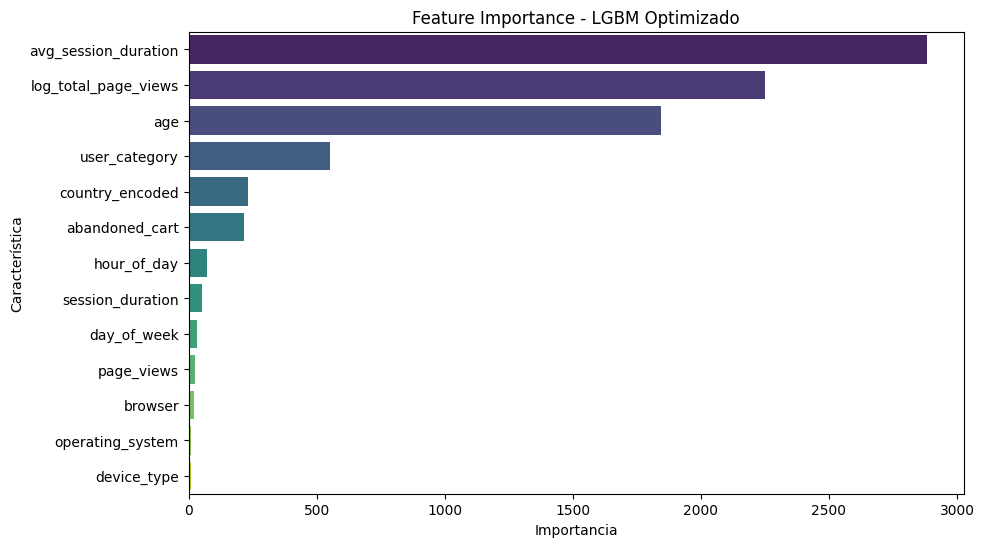

                 feature  importance
10  avg_session_duration        2882
11  log_total_page_views        2250
0                    age        1844
2          user_category         553
12       country_encoded         231
1         abandoned_cart         217
9            hour_of_day          73
7       session_duration          53
8            day_of_week          34
6             page_views          25
4                browser          22
5       operating_system          11
3            device_type           9


In [21]:
import json
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier

# 📌 1️⃣ Preparar los datos
# Se eliminan las columnas que no se utilizarán en el entrenamiento
X_train = full_train.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "marketing_target", "country"])
y_train = full_train["marketing_target"]

X_test = full_test.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "test_id", "country"])

# 📌 2️⃣ Configurar el modelo con los hiperparámetros óptimos
# Hiperparámetros obtenidos:
# {'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 50,
#  'max_depth': 7, 'learning_rate': 0.05, 'lambda_l2': 0, 'lambda_l1': 0.1, 'colsample_bytree': 1.0}
lgb_model_best = LGBMClassifier(
    subsample=1.0,
    num_leaves=31,
    n_estimators=100,
    min_child_samples=50,
    max_depth=7,
    learning_rate=0.05,
    lambda_l2=0,
    lambda_l1=0.1,
    colsample_bytree=1.0,
    random_state=42,
    n_jobs=1,           # Para evitar nested parallelism
    verbose=-1,
    force_col_wise=True,
    class_weight="balanced"
)

# 📌 3️⃣ Entrenar el modelo con todo el dataset de entrenamiento
lgb_model_best.fit(X_train, y_train)

# 📌 Obtener importancia de las características
feature_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": lgb_model_best.feature_importances_
}).sort_values(by="importance", ascending=False)

# 📌 Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x="importance", y="feature", palette="viridis")
plt.title("Feature Importance - LGBM Optimizado")
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.show()

# 📌 Mostrar el DataFrame ordenado
print(feature_importances)


## Eliminamos variables con "poca importancia" - 733/900 -> Baja el rendimiento pero es más ligero.

🔹 Resultados de Validación Cruzada:
F1 Macro: 0.9341 ± 0.0048
F1 Weighted: 0.9579 ± 0.0037
Accuracy: 0.9567 ± 0.0039
ROC-AUC: 0.9974 ± 0.0004
✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json


/tmp/ipykernel_31485/2034762983.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances, x="importance", y="feature", palette="viridis")


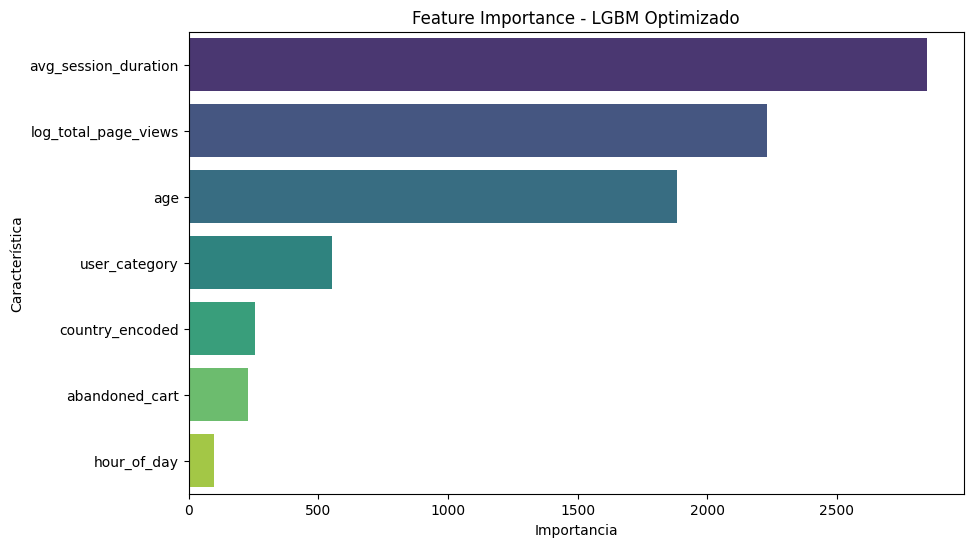

                feature  importance
4  avg_session_duration        2847
5  log_total_page_views        2232
0                   age        1885
2         user_category         554
6       country_encoded         256
1        abandoned_cart         229
3           hour_of_day          98


In [ ]:
# 📌 1️⃣ Preparar los datos
X_train = full_train.drop(columns=[
    "user_id", "session_id", "timestamp", "ip_address", "search_query", "marketing_target", "country",
    "device_type", "operating_system", "browser", "page_views", "day_of_week", "session_duration"
])
y_train = full_train["marketing_target"]

X_test = full_test.drop(columns=[
    "user_id", "session_id", "timestamp", "ip_address", "search_query", "test_id", "country",
    "device_type", "operating_system", "browser", "page_views", "day_of_week", "session_duration"
])

# 📌 2️⃣ Configurar el modelo con los mejores hiperparámetros
lgb_model = LGBMClassifier(
    subsample=1.0,
    num_leaves=31,
    n_estimators=100,
    min_child_samples=50,
    max_depth=7,
    learning_rate=0.05,
    lambda_l2=0,
    lambda_l1=0.1,
    colsample_bytree=1.0,
    random_state=42,
    n_jobs=1,  # Optimización de CPU
    verbose=-1,
    force_col_wise=True,
    class_weight="balanced"
)

# 📌 3️⃣ Evaluación con validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    lgb_model, X_train, y_train, cv=cv,
    scoring=["f1_macro", "f1_weighted", "accuracy", "roc_auc_ovr"],
    n_jobs=-1, return_train_score=False
)

# 📌 4️⃣ Mostrar resultados
print("🔹 Resultados de Validación Cruzada:")
print(f"F1 Macro: {np.mean(cv_results['test_f1_macro']):.4f} ± {np.std(cv_results['test_f1_macro']):.4f}")
print(f"F1 Weighted: {np.mean(cv_results['test_f1_weighted']):.4f} ± {np.std(cv_results['test_f1_weighted']):.4f}")
print(f"Accuracy: {np.mean(cv_results['test_accuracy']):.4f} ± {np.std(cv_results['test_accuracy']):.4f}")
print(f"ROC-AUC: {np.mean(cv_results['test_roc_auc_ovr']):.4f} ± {np.std(cv_results['test_roc_auc_ovr']):.4f}")

# 📌 5️⃣ Entrenar el modelo con todo el dataset
lgb_model.fit(X_train, y_train)

# 📌 6️⃣ Generar las predicciones
predictions = lgb_model.predict(X_test)

# 📌 7️⃣ Guardar predicciones en JSON
predictions_dict = {
    "target": {int(test_id): int(pred) for test_id, pred in zip(full_test["test_id"], predictions)}
}

with open("../predictions/predictions.json", "w") as f:
    json.dump(predictions_dict, f)

print("✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json")

# 📌 8️⃣ Importancia de características
feature_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": lgb_model.feature_importances_
}).sort_values(by="importance", ascending=False)

# 📌 Visualizar la importancia
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x="importance", y="feature", palette="viridis")
plt.title("Feature Importance - LGBM Optimizado")
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.show()

# 📌 Mostrar el DataFrame ordenado
print(feature_importances)


## class-weight scale_pos_weight - 731/900

In [23]:
# 📌 1️⃣ Preparar los datos
X_train = full_train.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "marketing_target", "country"])
y_train = full_train["marketing_target"]

X_test = full_test.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "test_id", "country"])

# 📌 2️⃣ Calcular `scale_pos_weight`
class_counts = y_train.value_counts()
scale_pos_weight = class_counts.min() / class_counts.max()  # Ajuste basado en distribución real

# 📌 3️⃣ Configurar modelo LightGBM con balanceo manual
lgb_model = LGBMClassifier(
    subsample=1.0,
    num_leaves=31,
    n_estimators=100,
    min_child_samples=50,
    max_depth=7,
    learning_rate=0.05,
    lambda_l2=0,
    lambda_l1=0.1,
    colsample_bytree=1.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True,
    scale_pos_weight=scale_pos_weight  # 🔥 Balanceo manual de clases
)

# 📌 4️⃣ Entrenar el modelo
lgb_model.fit(X_train, y_train)

# 📌 5️⃣ Generar predicciones
predictions = lgb_model.predict(X_test)

# 📌 6️⃣ Guardar predicciones en JSON
predictions_dict = {
    "target": {int(test_id): int(pred) for test_id, pred in zip(full_test["test_id"], predictions)}
}

with open("../predictions/predictions.json", "w") as f:
    json.dump(predictions_dict, f)

print("✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json")


✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json


## SMOTE - 696/900

In [24]:
from imblearn.over_sampling import SMOTE

# 📌 1️⃣ Preparar los datos
X_train = full_train.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "marketing_target", "country"])
y_train = full_train["marketing_target"]

X_test = full_test.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "test_id", "country"])

# 📌 2️⃣ Aplicar SMOTE para balancear las clases
smote = SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 📌 3️⃣ Configurar LightGBM con los mejores hiperparámetros
lgb_model = LGBMClassifier(
    subsample=1.0,
    num_leaves=31,
    n_estimators=100,
    min_child_samples=50,
    max_depth=7,
    learning_rate=0.05,
    lambda_l2=0,
    lambda_l1=0.1,
    colsample_bytree=1.0,
    random_state=42,
    verbose=-1,
    force_col_wise=True
)

# 📌 4️⃣ Entrenar el modelo con datos balanceados por SMOTE
lgb_model.fit(X_train_resampled, y_train_resampled)

# 📌 5️⃣ Generar predicciones
predictions = lgb_model.predict(X_test)

# 📌 6️⃣ Guardar predicciones en JSON
predictions_dict = {
    "target": {int(test_id): int(pred) for test_id, pred in zip(full_test["test_id"], predictions)}
}

with open("../predictions/predictions.json", "w") as f:
    json.dump(predictions_dict, f)

print("✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json")


✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json


## UnderSampling - 711/900

In [25]:
from imblearn.under_sampling import RandomUnderSampler

# 📌 1️⃣ Preparar los datos
X_train = full_train.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "marketing_target", "country"])
y_train = full_train["marketing_target"]

X_test = full_test.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "test_id", "country"])

# 📌 2️⃣ Aplicar **UnderSampling** para balancear las clases
undersampler = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# 📌 3️⃣ Configurar LightGBM con los mejores hiperparámetros
lgb_model = LGBMClassifier(
    subsample=1.0,
    num_leaves=31,
    n_estimators=100,
    min_child_samples=50,
    max_depth=7,
    learning_rate=0.05,
    lambda_l2=0,
    lambda_l1=0.1,
    colsample_bytree=1.0,
    random_state=42,
    verbose=-1,
    force_col_wise=True
)

# 📌 4️⃣ Entrenar el modelo con datos balanceados por UnderSampling
lgb_model.fit(X_train_resampled, y_train_resampled)

# 📌 5️⃣ Generar predicciones
predictions = lgb_model.predict(X_test)

# 📌 6️⃣ Guardar predicciones en JSON
predictions_dict = {
    "target": {int(test_id): int(pred) for test_id, pred in zip(full_test["test_id"], predictions)}
}

with open("../predictions/predictions.json", "w") as f:
    json.dump(predictions_dict, f)

print("✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json")


✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json


---

---
# Modelo Final - 739/900

In [49]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
# 📌 1️⃣ Preparar los datos
# Se eliminan las columnas que no se utilizarán en el entrenamiento
X_train = full_train.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "marketing_target", "country"])
y_train = full_train["marketing_target"]

X_test = full_test.drop(columns=["user_id", "session_id", "timestamp", "ip_address", "search_query", "test_id", "country"])

# 📌 2️⃣ Configurar el modelo con los hiperparámetros óptimos
# Hiperparámetros obtenidos:
# {'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 50,
#  'max_depth': 7, 'learning_rate': 0.05, 'lambda_l2': 0, 'lambda_l1': 0.1, 'colsample_bytree': 1.0}
lgb_model_best = LGBMClassifier(
    subsample=1.0,
    num_leaves=31,
    n_estimators=100,
    min_child_samples=50,
    max_depth=7,
    learning_rate=0.05,
    lambda_l2=0,
    lambda_l1=0.1,
    colsample_bytree=1.0,
    random_state=42,
    n_jobs=1,           # Para evitar nested parallelism
    verbose=-1,
    force_col_wise=True,
    class_weight="balanced"
)

# 📌 3️⃣ Entrenar el modelo con todo el dataset de entrenamiento
lgb_model_best.fit(X_train, y_train)


y_pred_train = lgb_model_best.predict(X_train)
y_pred_train_proba = lgb_model_best.predict_proba(X_train)


metrics = {
    "F1 Macro": f1_score(y_train, y_pred_train, average="macro"),
    "F1 Weighted": f1_score(y_train, y_pred_train, average="weighted"),
    "Accuracy": accuracy_score(y_train, y_pred_train),
    "ROC-AUC": roc_auc_score(y_train, y_pred_train_proba, multi_class="ovr", average="macro"),
}

print("🔹 Métricas del modelo:")
print(metrics)

# 📌 4️⃣ Generar las predicciones para el conjunto de test
predictions = lgb_model_best.predict(X_test)


# 📌 5️⃣ Guardar las predicciones en un archivo JSON
predictions_dict = {
    "target": {int(test_id): int(pred) for test_id, pred in zip(full_test["test_id"], predictions)}
}

with open("../predictions/predictions.json", "w") as f:
    json.dump(predictions_dict, f)

print("✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json")


🔹 Métricas del modelo:
{'F1 Macro': 0.9578520375951429, 'F1 Weighted': 0.9720961956440198, 'Accuracy': 0.9714992002326596, 'ROC-AUC': np.float64(0.9994901129415258)}
✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json


---
## Feature engineering

🔹 Métricas del modelo:
{'F1 Macro': 0.9497561722192328, 'F1 Weighted': 0.96665655212002, 'Accuracy': 0.9658281227279337, 'ROC-AUC': np.float64(0.9992181723900915)}


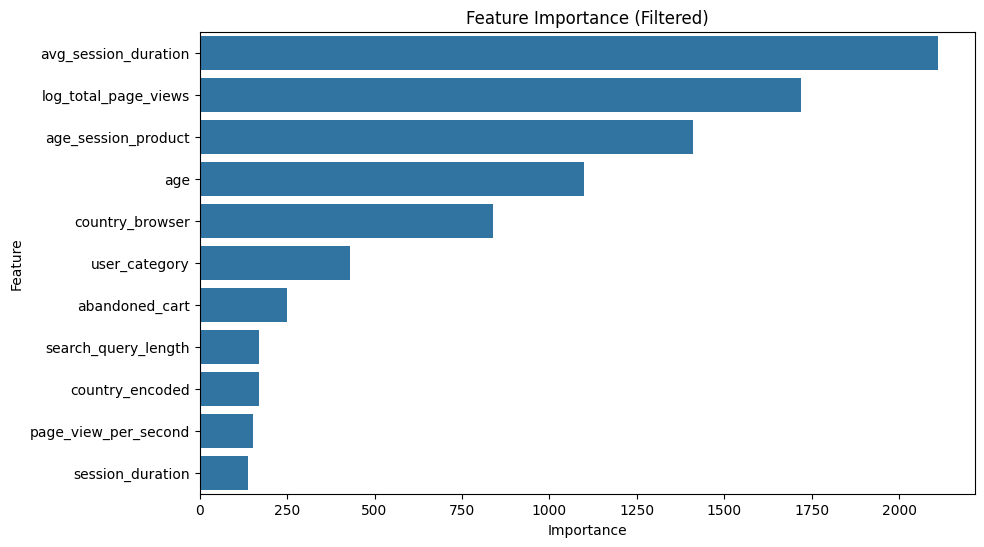

✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json


In [46]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

# 📌 1️⃣ Preparar los datos (no eliminamos todavía las columnas necesarias para las features)
features_to_drop_later = [
    "user_id", "session_id", "timestamp", "ip_address", "search_query", 
    "marketing_target", "country", "browser", "operating_system", 
    "day_of_week", "hour_of_day", 
    "device_type", "page_views"
]

X_train = full_train.copy()
y_train = full_train["marketing_target"]
X_test = full_test.copy()

# 📌 2️⃣ Generar nuevas características ANTES de eliminar columnas
for df, ref_df in [(X_train, full_train), (X_test, full_test)]:
    # df["device_os"] = df["device_type"].astype(str) + "_" + df["operating_system"].astype(str)
    df["country_browser"] = df["country_encoded"].astype(str) + "_" + df["browser"].astype(str)
    df["age_session_product"] = df["age"] * df["avg_session_duration"]
    df["page_view_per_second"] = df["page_views"] / (df["session_duration"] + 1e-6)
    df["search_query_length"] = ref_df["search_query"].str.len()

# 📌 3️⃣ Ahora eliminamos las columnas innecesarias
X_train = X_train.drop(columns=features_to_drop_later)
X_test = X_test.drop(columns=[col for col in features_to_drop_later if col in full_test.columns] + ["test_id"])

# 📌 4️⃣ Convertir variables categóricas
categorical_features = ["device_os", "country_browser"]
for col in categorical_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype("category")
    if col in X_test.columns:
        X_test[col] = X_test[col].astype("category")

# 📌 5️⃣ Configurar el modelo
lgb_model = LGBMClassifier(
    subsample=1.0,
    num_leaves=31,
    n_estimators=100,
    min_child_samples=50,
    max_depth=7,
    learning_rate=0.05,
    lambda_l2=0,
    lambda_l1=0.1,
    colsample_bytree=1.0,
    random_state=42,
    n_jobs=1,
    verbose=-1,
    force_col_wise=True,
    class_weight="balanced"
)

# 📌 6️⃣ Entrenar el modelo y obtener la importancia de las variables
lgb_model.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": lgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# 📌 7️⃣ Filtrar características con importancia > 200
selected_features = feature_importance[feature_importance["Importance"] > 200]["Feature"].tolist()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 📌 8️⃣ Re-entrenar el modelo con las características seleccionadas
lgb_model_best = LGBMClassifier(
    subsample=1.0,
    num_leaves=31,
    n_estimators=100,
    min_child_samples=50,
    max_depth=7,
    learning_rate=0.05,
    lambda_l2=0,
    lambda_l1=0.1,
    colsample_bytree=1.0,
    random_state=42,
    n_jobs=1,
    verbose=-1,
    force_col_wise=True,
    class_weight="balanced"
)

lgb_model_best.fit(X_train_selected, y_train)

# 📌 9️⃣ Generar predicciones
predictions = lgb_model_best.predict(X_test_selected)

# 📌 🔟 Calcular métricas de desempeño
y_pred_train = lgb_model_best.predict(X_train_selected)
y_pred_train_proba = lgb_model_best.predict_proba(X_train_selected)

metrics = {
    "F1 Macro": f1_score(y_train, y_pred_train, average="macro"),
    "F1 Weighted": f1_score(y_train, y_pred_train, average="weighted"),
    "Accuracy": accuracy_score(y_train, y_pred_train),
    "ROC-AUC": roc_auc_score(y_train, y_pred_train_proba, multi_class="ovr", average="macro"),
}

print("🔹 Métricas del modelo:")
print(metrics)

# 📌 1️⃣1️⃣ Visualizar Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"])
plt.title("Feature Importance (Filtered)")
plt.show()

# 📌 1️⃣2️⃣ Guardar las predicciones en un archivo JSON
predictions_dict = {
    "target": {int(test_id): int(pred) for test_id, pred in zip(full_test["test_id"], predictions)}
}

with open("../predictions/predictions.json", "w") as f:
    json.dump(predictions_dict, f)

print("✅ Modelo LightGBM entrenado y predicciones guardadas en predictions/predictions.json")


## RandomSearchCV + feature engineering

In [48]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

# 📌 1️⃣ Preparar los datos (sin eliminar aún las columnas necesarias para las features)
features_to_drop_later = [
    "user_id", "session_id", "timestamp", "ip_address", "search_query", 
    "marketing_target", "country"
]

X_train = full_train.copy()
y_train = full_train["marketing_target"]
X_test = full_test.copy()

# 📌 2️⃣ Generar nuevas características ANTES de eliminar columnas
for df, ref_df in [(X_train, full_train), (X_test, full_test)]:
    df["country_browser"] = df["country_encoded"].astype(str) + "_" + df["browser"].astype(str)
    df["age_session_product"] = df["age"] * df["avg_session_duration"]
    df["page_view_per_second"] = df["page_views"] / (df["session_duration"] + 1e-6)
    df["search_query_length"] = ref_df["search_query"].str.len()

# 📌 3️⃣ Ahora eliminamos las columnas innecesarias
X_train = X_train.drop(columns=features_to_drop_later)
X_test = X_test.drop(columns=[col for col in features_to_drop_later if col in full_test.columns] + ["test_id"])

# 📌 4️⃣ Convertir variables categóricas
categorical_features = ["country_browser"]
for col in categorical_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype("category")
    if col in X_test.columns:
        X_test[col] = X_test[col].astype("category")

# 📌 5️⃣ Definir el espacio de hiperparámetros para RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, -1],  # -1 indica sin límite de profundidad
    'num_leaves': [15, 31, 63],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'lambda_l1': [0, 0.1, 0.5],
    'lambda_l2': [0, 0.1, 0.5]
}

# 📌 6️⃣ Configurar el modelo base
lgb_model = LGBMClassifier(
    random_state=42,
    n_jobs=1,
    verbose=-1,
    force_col_wise=True
)

# 📌 7️⃣ Configurar la búsqueda de hiperparámetros
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_distributions,
    n_iter=30,          # Número de combinaciones a probar
    scoring='f1_macro',  # Usamos f1_macro como métrica de evaluación
    cv=5,
    random_state=42,
    n_jobs=1            # Ejecutar de forma secuencial para evitar sobrecarga
)

# 📌 8️⃣ Entrenar la búsqueda de hiperparámetros
random_search.fit(X_train, y_train)

# 📌 9️⃣ Mostrar los mejores hiperparámetros
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Mejores hiperparámetros:", best_params)
print("Mejor puntuación f1_macro:", best_score)

# 📌 🔟 Guardar los mejores hiperparámetros en JSON
with open("../predictions/best_params.json", "w") as f:
    json.dump({"best_params": best_params, "best_score": best_score}, f)

# 📌 1️⃣1️⃣ Entrenar el modelo final con los mejores hiperparámetros
lgb_model_best = LGBMClassifier(**best_params, random_state=42, n_jobs=1, verbose=-1, force_col_wise=True)
lgb_model_best.fit(X_train, y_train)

# 📌 1️⃣2️⃣ Generar predicciones finales
predictions = lgb_model_best.predict(X_test)

# 📌 1️⃣3️⃣ Calcular métricas de desempeño
y_pred_train = lgb_model_best.predict(X_train)
y_pred_train_proba = lgb_model_best.predict_proba(X_train)

metrics = {
    "F1 Macro": f1_score(y_train, y_pred_train, average="macro"),
    "F1 Weighted": f1_score(y_train, y_pred_train, average="weighted"),
    "Accuracy": accuracy_score(y_train, y_pred_train),
    "ROC-AUC": roc_auc_score(y_train, y_pred_train_proba, multi_class="ovr", average="macro"),
}

print("🔹 Métricas del modelo final:")
print(metrics)

# 📌 1️⃣4️⃣ Guardar las predicciones en JSON
predictions_dict = {
    "target": {int(test_id): int(pred) for test_id, pred in zip(full_test["test_id"], predictions)}
}

with open("../predictions/predictions.json", "w") as f:
    json.dump(predictions_dict, f)

print("✅ Modelo LightGBM optimizado entrenado y predicciones guardadas en predictions/predictions.json")


Mejores hiperparámetros: {'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 50, 'max_depth': 7, 'learning_rate': 0.05, 'lambda_l2': 0, 'lambda_l1': 0.1, 'colsample_bytree': 1.0}
Mejor puntuación f1_macro: 0.6366082864841648
🔹 Métricas del modelo final:
{'F1 Macro': 0.9863346092892344, 'F1 Weighted': 0.9915578353909403, 'Accuracy': 0.9915660898647666, 'ROC-AUC': np.float64(0.9995730587643413)}
✅ Modelo LightGBM optimizado entrenado y predicciones guardadas en predictions/predictions.json
